In [21]:
# Data Manipulation
import numpy as np
import pandas as pd
import os
# Visualization/Image Processing
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense, Activation
from PIL import Image
# Other
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
import xml.etree.ElementTree as ET
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [2]:
#Codice per rendere l'immagine quadrata 
def make_square(im, fill_color=(0, 0, 0, 0)):
    x, y = im.shape[0], im.shape[1]
    size = max(x, y)
    BLACK = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im,int((size-y)/2),int((size-y)/2),int((size-x)/2),int((size-x)/2),cv2.BORDER_CONSTANT, value = BLACK)
    return new_im

In [3]:
#Bounding box with one tumor
lab = ['axial_t1wce_2_class','coronal_t1wce_2_class', 'sagittal_t1wce_2_class']
X_train = []
bb = []
temp_array  = []
image_size = 180
for i in lab:
    folderPath = os.path.join('./',i,'images','train')
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        if img.shape[0] != img.shape[1]:
            img = make_square(img, fill_color=(0, 0, 0, 0))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
image_index = 0
bb_train = np.zeros((len(X_train),4))
for i in lab:
    labelsPath = os.path.join('./',i,'labels','train')
    for j in tqdm(os.listdir(labelsPath)):
        with open(os.path.join(labelsPath,j), encoding="utf-8") as f:
            for line in f:
                num = list(map(float,line.split(" ")))
                temp_array = []
                for k in num:
                    k = k * image_size
                    temp_array.append(k)
                temp_array.pop(0)
                #print(temp_array)
                bb_train[image_index] = np.array([temp_array])
                #print(bb_train[image_index])
            image_index += 1

X_test = []
for i in lab:
    folderPath = os.path.join('./',i,'images','test')
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        if img.shape[0] != img.shape[1]:
            img = make_square(img, fill_color=(0, 0, 0, 0))
        img = cv2.resize(img,(image_size, image_size))
        X_test.append(img)
image_index = 0
bb_test = np.zeros((len(X_test),4))
for i in lab:
    labelsPath = os.path.join('./',i,'labels','test')
    for j in tqdm(os.listdir(labelsPath)):
        with open(os.path.join(labelsPath,j), encoding="utf-8") as f:
            for line in f:
                num = list(map(float,line.split(" ")))
                temp_array = []
                for k in num:
                    k = k * image_size
                    temp_array.append(k)
                temp_array.pop(0)
                #print(temp_array)
                bb_test[image_index] = np.array([temp_array])
                #print(bb_test[image_index])
            image_index += 1

100%|█████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 189.01it/s]


In [20]:
len(X_train)

790

In [4]:
#prepare dataset 
train_dataset = ImageDataGenerator()
val_dataset = ImageDataGenerator()

In [5]:
#array conversion
X_train = np.array(X_train)
X_test = np.array(X_test)

In [6]:
#Shuffle
X_train, bb_train = shuffle(X_train, bb_train)

In [7]:
#Validation set created
X_train, X_val, bb_train, bb_val = train_test_split(X_train, bb_train, test_size = 0.1, shuffle = False)

In [8]:
BATCH_SIZE = 16
save_path = os.path.join('./', 'model_from_scratch')
train_dataset = train_dataset.flow(X_train, bb_train, batch_size = BATCH_SIZE)
val_dataset = val_dataset.flow(X_val, bb_val, batch_size = BATCH_SIZE)

In [9]:
#Data augmentation
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        #layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2)
    ],
    name="img_augmentation",
)

In [10]:
conv_base = keras.applications.EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [15]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True
    ),
    ShowTestImages()
]

In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Flatten()(model)
model = tf.keras.layers.Dense(4,name='coords')(model)
model = tf.keras.models.Model(inputs=effnet.inputs, outputs = model)

In [15]:
IMG_SIZE = 180
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
model = img_augmentation(inputs)
model = keras.applications.efficientnet.preprocess_input(model)
model = conv_base(model)
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Flatten()(model)
model = tf.keras.layers.Dense(4,name='coords')(model)
model = tf.keras.models.Model(inputs=inputs, outputs = model)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 img_augmentation (Sequentia  (None, 180, 180, 3)      0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 6, 6, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 flatten (Flatten)           (None, 1280)              0     

In [16]:
model.compile(
    loss={
        'coords': 'mae'
    },
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics={
        'coords': 'accuracy'
    }
)

Epoch 1/5
50/50 [==============================] - ETA: 0s - loss: 3.2519 - accuracy: 0.9595
Epoch 1: val_loss improved from inf to 3.03838, saving model to .\model_from_scratch


INFO:tensorflow:Assets written to: .\model_from_scratch\assets


INFO:tensorflow:Assets written to: .\model_from_scratch\assets


7/7 [==============================] - 8s 1s/step


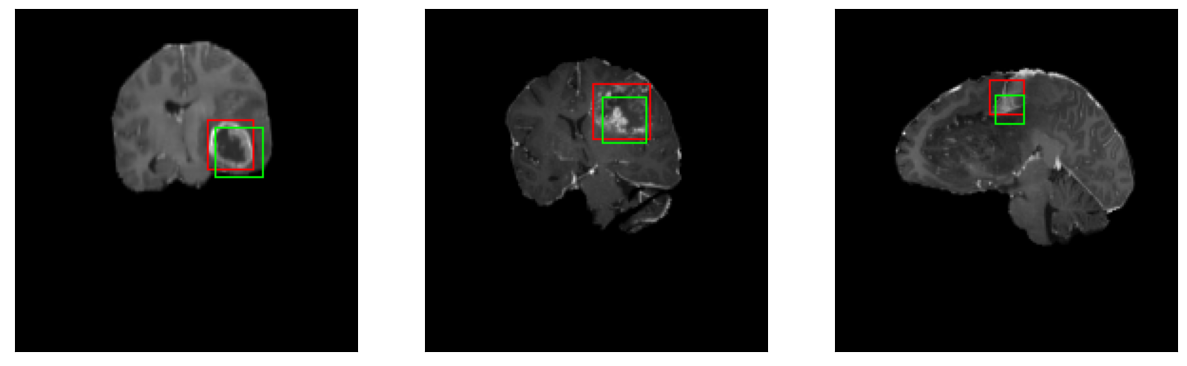

50/50 [==============================] - 213s 4s/step - loss: 3.2519 - accuracy: 0.9595 - val_loss: 3.0384 - val_accuracy: 0.9432
Epoch 2/5
50/50 [==============================] - ETA: 0s - loss: 3.1409 - accuracy: 0.9608
Epoch 2: val_loss improved from 3.03838 to 2.83656, saving model to .\model_from_scratch


INFO:tensorflow:Assets written to: .\model_from_scratch\assets


INFO:tensorflow:Assets written to: .\model_from_scratch\assets


7/7 [==============================] - 8s 1s/step


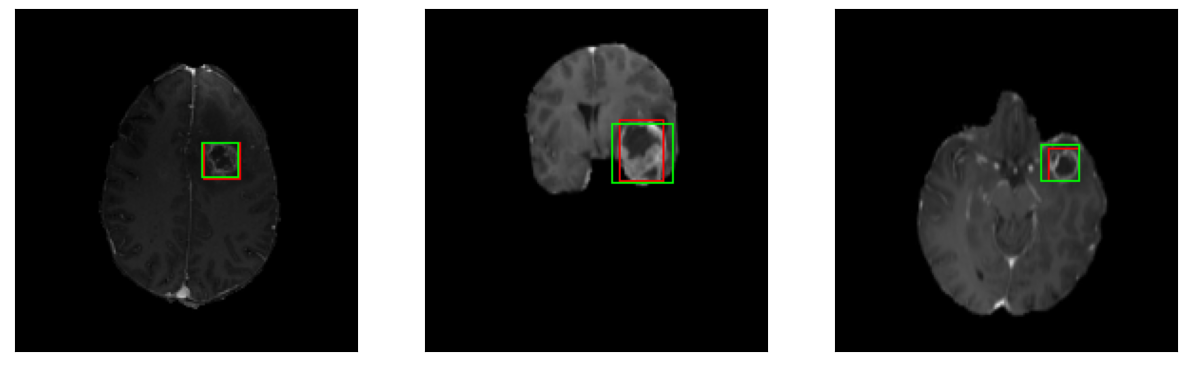

50/50 [==============================] - 253s 5s/step - loss: 3.1409 - accuracy: 0.9608 - val_loss: 2.8366 - val_accuracy: 0.9659
Epoch 3/5
50/50 [==============================] - ETA: 0s - loss: 3.1710 - accuracy: 0.9620
Epoch 3: val_loss improved from 2.83656 to 2.01168, saving model to .\model_from_scratch


INFO:tensorflow:Assets written to: .\model_from_scratch\assets


INFO:tensorflow:Assets written to: .\model_from_scratch\assets


7/7 [==============================] - 9s 1s/step


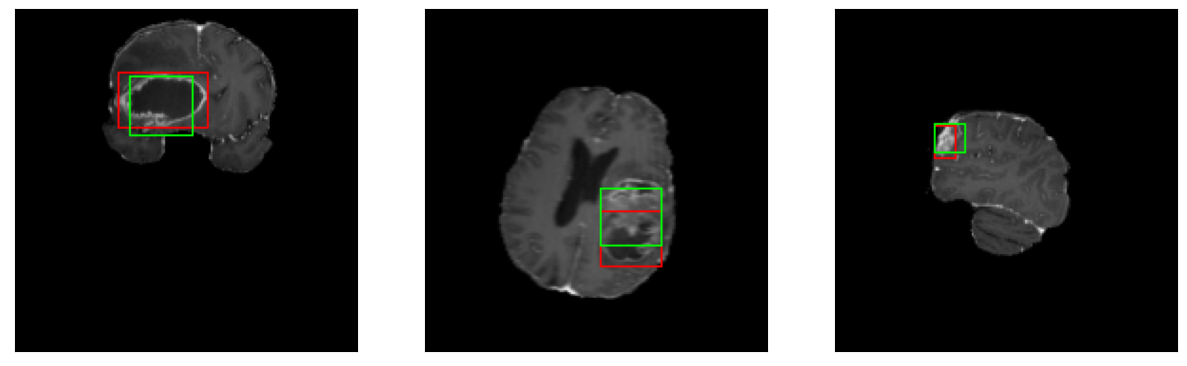

50/50 [==============================] - 228s 5s/step - loss: 3.1710 - accuracy: 0.9620 - val_loss: 2.0117 - val_accuracy: 0.9886
Epoch 4/5
50/50 [==============================] - ETA: 0s - loss: 3.0561 - accuracy: 0.9633
Epoch 4: val_loss did not improve from 2.01168
7/7 [==============================] - 9s 1s/step


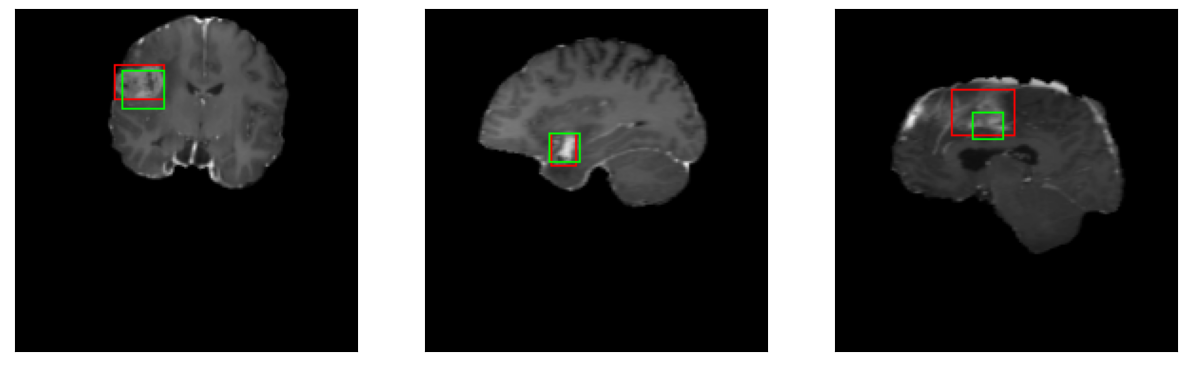

50/50 [==============================] - 166s 3s/step - loss: 3.0561 - accuracy: 0.9633 - val_loss: 2.7711 - val_accuracy: 0.9773
Epoch 5/5
50/50 [==============================] - ETA: 0s - loss: 3.0549 - accuracy: 0.9646
Epoch 5: val_loss did not improve from 2.01168
7/7 [==============================] - 9s 1s/step


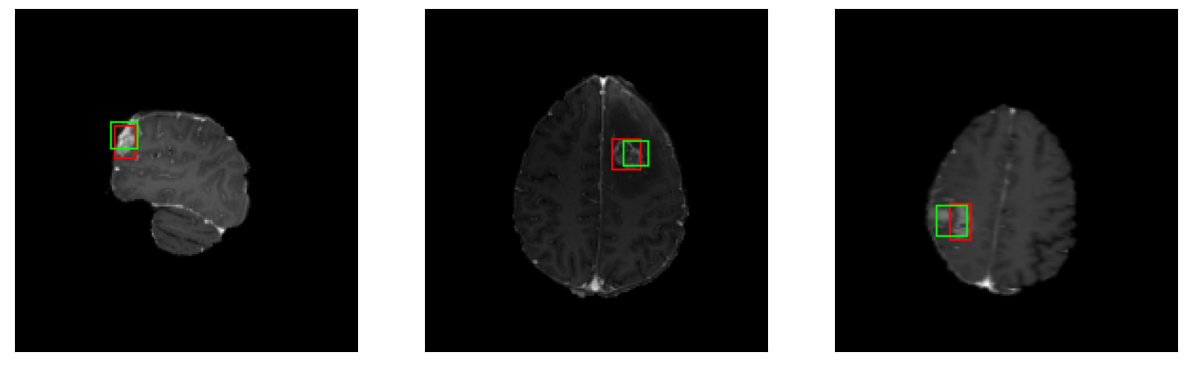

50/50 [==============================] - 170s 3s/step - loss: 3.0549 - accuracy: 0.9646 - val_loss: 2.2765 - val_accuracy: 0.9773


In [17]:
model.fit(
        train_dataset,
        epochs=5,
        validation_data = val_dataset,
        callbacks = callbacks_list
        )

In [13]:
# Draw the predicted bounding boxes
def display_image(img, bbox_coords, pred_coords):
    if len(bbox_coords) == 4: #in rosso
        xmin, ymin, height, width = bbox_coords
        img = cv2.rectangle(img, (int(xmin-height/2), int(ymin-width/2)), (int(xmin+height/2), int(ymin+width/2)), (255, 0, 0), 1)
        
    if len(pred_coords) == 4: #in verde
        xmin1, ymin1, height1, width1 = pred_coords
        img = cv2.rectangle(img, (int(xmin1-height1/2), int(ymin1-width1/2)), (int(xmin1+height1/2), int(ymin1+width1/2)), (0, 255, 0), 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [14]:
#To test the model
def test_model(model):
    rand_index = np.random.randint(0, bb_test.shape[0])
    pred_bbox = model.predict(X_test)[rand_index]
    img_original = X_test[rand_index]
    img = img_original.copy()
    coords = bb_test[rand_index]
    #example, label = next(datagen)
    #X = example['image']
    #y = label['coords']
    #pred_bbox = model.predict(X)[0]
    #img = X[0]
    #gt_coords = y[0]
    
    display_image(img,bbox_coords = coords, pred_coords=pred_bbox)

def test(model):
    
    plt.figure(figsize=(15,7))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        test_model(model)    
    plt.show()

class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)
        

In [49]:
#Save model
model.save('./model_efficientNet')

INFO:tensorflow:Assets written to: ./model_efficientNet\assets


INFO:tensorflow:Assets written to: ./model_efficientNet\assets


In [37]:
#Save model
model.save('./model_from_scratch')

INFO:tensorflow:Assets written to: ./model_from_scratch\assets


INFO:tensorflow:Assets written to: ./model_from_scratch\assets


In [12]:
model = tf.keras.models.load_model('./model_efficientNet')

In [36]:
model = tf.keras.models.load_model('./model_from_scratch')

<AxesSubplot:>

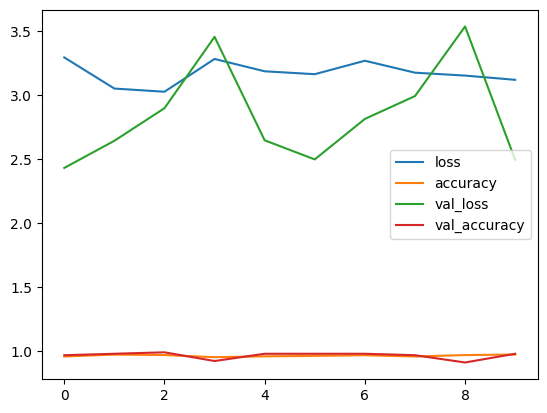

In [50]:
pd.DataFrame(model.history.history).plot()